In [3]:
%matplotlib inline

import pdb
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from nnCostFunction import nn_cost_function

import warnings
warnings.filterwarnings('ignore')

## Neural net cost function with regularization

10


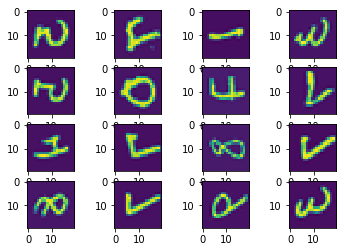

10.441459672777977

In [2]:
# 5000 Mnist digits
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

# clean up data
for index, value in enumerate(y):
    if value == 10:
        y[index] = 0

# 5000 samples, 500 from each class
num_samples = X.shape[0]

# num of pixels per sample
dim_samples = X.shape[1]

# digits from 0 through 9
num_classes = np.unique(y).size
print(num_classes)
# randomly select 16 image to display
fig = plt.figure()
for i in range(1, 17):
    index = np.random.randint(low=0, high=4999, size=1)
    image = np.reshape(X[index, :], (20, 20))
    fig.add_subplot(4, 4, i)
    plt.imshow(image)
# end
plt.show()

# load pre-learned weights
weights = loadmat('ex4weights.mat')

nn_cost_function(weights, 400, 25, 10, X, y, 0)

